# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/nareshsharma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The following meanings are equivalent of NaN (by looking at DIAS Attributes - Values 2017.xlsx)- 
1. The value of -1, represents an unknown value
2. For a few other attrbutes a value of 0 or 9 or 10 is used to represent an unknow value... we'll takle this later


In [4]:
print(azdias.shape)
azdias.info(verbose=True)

(891221, 366)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1              

In [5]:

# clean up
# Step 1 
#   Select only the colums that are part of the attribute list
#   Replace all unknown values with a NaN
# Step 2... 
#   identify attributes which have a significant percent of their values as NaN...
#   drop columns which has more than 50% of their values as NA/NULL
#   Replace the rest of the NaN values appropriate... look at the data distribution to take a call
# Step 3...
#   use hotfixing to convert categories into features

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
# Read in only the rows with the attribute names
# This serves 2 purposes.. first we get the attribut names... 
# Also, if one of the values is unknown... then, it is present as part of the first row 
# and hence we get that info as well
df_attrs = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
df_attrs.drop(columns=df_attrs.columns[0], inplace=True)
df_attrs.dropna(inplace=True)
df_attrs = df_attrs.reset_index()
print(df_attrs.shape)
df_attrs.head()

(314, 6)


,index,Attribute,Description,Value,Meaning,Type
0,0,AGER_TYP,best-ager typology,-1,unknown,Category
1,5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Numerical
2,11,ALTER_HH,main age within the household,0,unknown / no main age detectable,Numerical
3,33,ANREDE_KZ,gender,"-1, 0",unknown,Category
4,36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),Numerical


In [8]:
df_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
df_values.drop(columns=df_values.columns[0], inplace=True)
# df_values.dropna(inplace=True)
df_values.Attribute = df_values.Attribute.fillna(method='ffill')
# df_values = df_values.reset_index()
print(df_values.shape)
df_values.head()

(2258, 5)


,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,Category
1,AGER_TYP,NaN,0,no classification possible,NaN
2,AGER_TYP,NaN,1,passive elderly,NaN
3,AGER_TYP,NaN,2,cultural elderly,NaN
4,AGER_TYP,NaN,3,experience-driven elderly,NaN


* Note that above, we have introduced a new column called Type. We have marked all Attributes that ***doesn't*** seem like something that could be measured as a number, as a category.

In [9]:
common_columns = (set(list(df_attrs.Attribute)) & set(list(azdias.columns)))
common_columns

{'AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER

In [10]:
list(azdias.columns)
azdias_sel_cols = azdias[common_columns]
print(azdias_sel_cols.shape)
list(azdias_sel_cols.columns.sort_values())

(891221, 272)


['AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER

In [11]:
azdias_sel_cols.D19_TELKO_DATUM.unique()

array([10,  6,  9,  8,  7,  5,  4,  2,  1,  3])

In [12]:
# for colname in common_columns:
#     if df_attrs[df_attrs.Attribute==colname].Meaning.values[0].find('unknown') > -1:
#         unknown_values = str(df_attrs[df_attrs.Attribute==colname].Value.values[0])
#         unknown_values = list(map(int, unknown_values.strip().split(','))) 
# #         print( colname, unknown_values)
# #         print(azdias_sel_cols.loc[azdias_sel_cols[colname].isin(unknown_values), colname].count())
#         azdias_sel_cols.loc[azdias_sel_cols[colname].isin(unknown_values), colname] = np.NaN

# We want to do 2 things here:
# 1. replace the values representing unknown with NaN
# 2. For category type of attributes:
# .  replace any unknown values with NaN (values which are not mentioned in the values file)
# while doing the above, ignore columns which are continuous in nature
def mark_invalid_values_as_null(df):
    categorical_dict = {}
    df_categorical = pd.DataFrame()
    for colname in common_columns:
        print(df_attrs[df_attrs.Attribute==colname].Type.values[0])
        if df_attrs[df_attrs.Attribute==colname].Type.values[0] == 'Category': 
            print(colname)
#             valid_values = df_values[df_values.Attribute==colname].Value.values
            valid_values = df_values[(df_values.Attribute==colname) & (df_values.Meaning.str.contains('unknown')==False)].Value.values
            print('valid values for column:{}, are {}'.format(colname, valid_values))

            m = df[colname].isin(valid_values)
            df[colname] = df[colname].where(m, other=np.nan)
            # make this column as categorical, so that get_dummies works consistently
            categorical_dict[colname] = pd.Categorical(valid_values)
#             pd.Categorical(df['col'], categories=['a', 'b', 'c', 'd'])
            print(sum(m))
    return df, categorical_dict

def mark_unknown_as_null(df):
    if df_attrs[df_attrs.Attribute==colname].Meaning.values[0].find('unknown') > -1:
        unknown_values = str(df_attrs[df_attrs.Attribute==colname].Value.values[0])
        unknown_values = list(map(int, unknown_values.strip().split(','))) 
        df.loc[df[colname].isin(unknown_values), colname] = np.NaN
    return df


In [13]:
df_values[(df_values.Attribute=='TITEL_KZ') & (df_values.Meaning.str.contains('unknown')==False)].Value.values
# df_values[(df_values.Attribute=='TITEL_KZ')] # ['Meaning'].astype(str) # .values[0].find('unknown') > -1
# df_values[df_values.Meaning.find('unknown')>-1]
# df_values.query('Attribute=="TITEL_KZ" and Meaning."unknown"')

array([1, 2, 3, 4, 5], dtype=object)

In [14]:
azdias_sel_cols, categorical_dict = mark_invalid_values_as_null(azdias_sel_cols)
# azdias_sel_cols = mark_unknown_as_null(azdias_sel_cols)

Numerical
Numerical
Numerical
Category
D19_GESAMT_ONLINE_DATUM
valid values for column:D19_GESAMT_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
891221
Category
D19_BANKEN_DATUM
valid values for column:D19_BANKEN_DATUM, are [1 2 3 4 5 6 7 8 9 10]


/Users/nareshsharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


891221
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
HEALTH_TYP
valid values for column:HEALTH_TYP, are [0 1 2 3]
780025
Numerical
Category
GFK_URLAUBERTYP
valid values for column:GFK_URLAUBERTYP, are [1 2 3 4 5 6 7 8 9 10 11 12]
886367
Numerical
Category
D19_GESAMT_DATUM
valid values for column:D19_GESAMT_DATUM, are [1 2 3 4 5 6 7 8 9 10]
891221
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
CAMEO_DEUG_2015
valid values for column:CAMEO_DEUG_2015, are [1 2 3 4 5 6 7 8 9]
332884
Numerical
Numerical
Numerical
Category
LP_FAMILIE_FEIN
valid values for column:LP_FAMILIE_FEIN, are [1 2 3 4 5 6 7 8 9 10 11]
813429
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
D19_TELKO_OFFLINE_DATUM
valid values for column:D19_TELKO_OFFLINE_DATUM, are [1 2 3 4 5 6

In [15]:
categorical_dict['D19_TELKO_OFFLINE_DATUM']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]

In [16]:
azdias_sel_cols.head()

,D19_BANKEN_ANZ_24,KBA05_SEG4,WOHNLAGE,D19_GESAMT_ONLINE_DATUM,D19_BANKEN_DATUM,KBA05_SEG5,KBA13_SEG_KOMPAKTKLASSE,D19_BANKEN_ONLINE_QUOTE_12,GEBURTSJAHR,KBA13_SEG_VAN,KBA05_CCM2,HEALTH_TYP,KBA13_SITZE_4,GFK_URLAUBERTYP,KBA05_HERST1,D19_GESAMT_DATUM,KBA05_CCM1,KBA13_CCM_2501,REGIOTYP,KBA13_CCM_1000,D19_GESAMT_ANZ_12,KBA05_DIESEL,KBA05_SEG10,KBA13_VORB_3,FINANZ_SPARER,KBA13_HERST_BMW_BENZ,SEMIO_FAM,KBA05_ZUL2,KBA13_KW_120,KBA05_ZUL3,KBA13_KMH_140_210,KBA13_CCM_0_1400,ALTERSKATEGORIE_GROB,KBA13_MAZDA,KBA13_SEG_SPORTWAGEN,SEMIO_KRIT,KBA13_FORD,KBA13_HALTER_45,KBA13_SEG_SONSTIGE,KBA05_ZUL1,CAMEO_DEUG_2015,KBA05_KRSZUL,KBA13_FAB_ASIEN,KBA13_KRSZUL_NEU,LP_FAMILIE_FEIN,KBA05_SEG1,ORTSGR_KLS9,KBA13_SEG_WOHNMOBILE,KBA13_VORB_2,KBA05_KW1,KBA13_BJ_2008,D19_TELKO_OFFLINE_DATUM,D19_VERSI_ANZ_24,KBA13_CCM_1500,KBA13_KW_90,PRAEGENDE_JUGENDJAHRE,KBA05_HERST5,KBA05_KW2,ZABEOTYP,LP_STATUS_FEIN,KBA13_KW_30,FINANZ_UNAUFFAELLIGER,LP_FAMILIE_GROB,SEMIO_LUST,KBA05_MAXSEG,KBA05_MAXBJ,KBA05_KRSKLEIN,D19_VERSI_ANZ_12,KKK,KBA05_MOD1,TITEL_KZ,KBA13_HERST_FORD_OPEL,SEMIO_KULT,KBA13_KMH_180,KBA05_ALTER4,ONLINE_AFFINITAET,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_BAUMAX,KBA13_HERST_SONST,VERS_TYP,D19_VERSAND_OFFLINE_DATUM,FINANZ_VORSORGER,PLZ8_ANTG2,KBA13_KW_50,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,KBA05_HERSTTEMP,KBA13_KRSAQUOT,KBA05_HERST3,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,GEBAEUDETYP,KBA13_ALTERHALTER_60,INNENSTADT,KBA05_MOD3,KBA13_KW_0_60,KBA05_KRSOBER,PLZ8_BAUMAX,KONSUMNAEHE,KBA13_CCM_1800,KBA13_KRSSEG_OBER,KBA13_SEG_MINIWAGEN,KBA05_VORB1,D19_TELKO_DATUM,EWDICHTE,KBA13_SEG_KLEINST,KBA05_SEG3,KBA13_HERST_AUDI_VW,KBA13_HALTER_60,KBA13_KMH_140,NATIONALITAET_KZ,D19_VERSAND_ONLINE_DATUM,ANREDE_KZ,KBA13_CCM_1400,KBA13_SEG_OBERKLASSE,D19_VERSAND_ONLINE_QUOTE_12,LP_LEBENSPHASE_GROB,KBA05_KRSHERST3,ANZ_PERSONEN,KBA05_MOD4,KBA13_CCM_3001,KBA13_ALTERHALTER_45,KBA13_KW_110,D19_VERSAND_ANZ_12,KBA13_HALTER_66,KBA13_CCM_1600,KBA13_SEG_MINIVANS,KBA13_VORB_0,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,ANZ_TITEL,KBA13_RENAULT,KBA13_SEG_KLEINWAGEN,KBA13_KMH_110,KBA05_SEG7,KBA05_VORB0,RELAT_AB,KBA13_CCM_2500,W_KEIT_KIND_HH,KBA05_KRSHERST2,BALLRAUM,KBA05_MAXAH,KBA05_ALTER3,KBA13_KW_70,D19_TELKO_ONLINE_DATUM,KBA05_ANTG4,D19_KONSUMTYP,KBA05_KW3,KBA13_FAB_SONSTIGE,KBA05_MODTEMP,KBA05_ALTER2,KBA13_HALTER_25,KBA13_HALTER_55,KBA13_KMH_251,FINANZ_ANLEGER,KBA13_KW_60,KBA13_SEG_UTILITIES,KBA13_HALTER_40,KBA13_BMW,KBA05_SEG2,HH_EINKOMMEN_SCORE,D19_GESAMT_ONLINE_QUOTE_12,SEMIO_ERL,KBA13_CCM_1200,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_ALTERHALTER_61,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,KBA13_KRSSEG_VAN,KBA13_SITZE_5,KBA13_VORB_1,PLZ8_ANTG4,PLZ8_HHZ,ALTER_HH,SEMIO_DOM,KBA13_SEG_MITTELKLASSE,KBA13_CCM_3000,KBA13_HALTER_50,KBA05_ALTER1,CAMEO_DEU_2015,KBA13_MERCEDES,D19_VERSAND_DATUM,D19_TELKO_ANZ_12,KBA13_NISSAN,KBA13_KW_61_120,KBA05_MOD8,KBA05_KRSVAN,KBA13_FIAT,KBA13_KW_80,KBA05_HERST4,D19_BANKEN_ANZ_12,AGER_TYP,KBA13_BJ_2000,KBA13_KW_121,GREEN_AVANTGARDE,SEMIO_REL,SEMIO_TRADV,KBA05_MOTOR,PLZ8_ANTG1,D19_GESAMT_OFFLINE_DATUM,KBA13_HALTER_65,KBA13_KRSHERST_AUDI_VW,KBA13_OPEL,MOBI_REGIO,KBA13_BJ_1999,KBA05_ZUL4,KBA13_SEG_GROSSRAUMVANS,KBA13_PEUGEOT,SEMIO_KAEM,KBA05_HERST2,SEMIO_SOZ,KBA13_SITZE_6,MIN_GEBAEUDEJAHR,KBA13_VW,KBA13_BJ_2004,KBA05_VORB2,KBA13_HALTER_30,KBA13_BJ_2006,KBA05_CCM4,KBA13_VORB_1_2,D19_VERSAND_ANZ_24,KBA05_SEG6,KBA05_GBZ,KBA13_BJ_2009,KBA13_CCM_2000,PLZ8_ANTG3,PLZ8_GBZ,KBA05_ANTG2,D19_TELKO_ANZ_24,CJT_GESAMTTYP,KBA05_MOD2,KBA05_CCM3,ANZ_HH_TITEL,KBA13_KMH_250,KBA13_AUDI,KBA13_KRSHERST_FORD_OPEL,D19_BANKEN_ONLINE_DATUM,KBA13_HALTER_20,KBA05_SEG9,SEMIO_PFLICHT,GEBAEUDETYP_RASTER,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MOTRAD,KBA13_HALTER_35,KBA13_MOTOR,OST_WEST_KZ,KBA13_HERST_EUROPA,KBA05_KRSAQUOT,FINANZ_MINIMALIST,KBA05_AUTOQUOT,KBA13_ALTERHALTER_30,D19_BANKEN_OFFLINE_DATUM,SHOPPER_TYP,KBA13_KRSSEG_KLEIN,SEMIO_RAT,KBA13_AUTOQUOTE,KBA05_SEG8,KBA05_MAXHERST,KBA13_KMH_211,KBA05_KRSHERST1,WOHNDAUER_2008,SEMIO_MAT,KBA05_FRAU,KBA13_KMH_0_140,FINANZTYP,D19_GESAMT_ANZ_24,KBA05_MAXVORB,LP_STATUS_GROB,KB

In [17]:
null_data = azdias_sel_cols.isnull().sum()[azdias_sel_cols.isnull().sum() > 0]
dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/azdias_sel_cols.shape[0], 2)}
df_nulls = pd.DataFrame(data=dict, index=null_data.index)
df_nulls.sort_values(by='pct', ascending=False, inplace=True)

In [18]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()

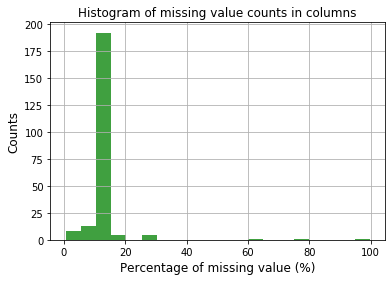

In [19]:
plot_hist_missing_col(df_nulls)

In [20]:
# it is c;ear from the above that most of the data has less than 20% of their values as null.
print(df_nulls[df_nulls.pct > 20])
df_nulls[df_nulls.pct > 20].count()

                              nulls    pct
TITEL_KZ                     889061  99.76
AGER_TYP                     677503  76.02
CAMEO_DEUG_2015              558337  62.65
D19_GESAMT_ONLINE_QUOTE_12   257113  28.85
D19_BANKEN_ONLINE_QUOTE_12   257113  28.85
D19_VERSAND_ONLINE_QUOTE_12  257113  28.85
D19_KONSUMTYP                257113  28.85


nulls    7
pct      7
dtype: int64

In [21]:
# remove the columns from the dataset that have more than 20% of their values as null, one way or the other
azdias_sel_cols.drop(columns=df_nulls[df_nulls.pct>20].index, inplace=True)
final_column_list = azdias_sel_cols.columns

/Users/nareshsharma/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
azdias_sel_cols.describe()

,D19_BANKEN_ANZ_24,KBA05_SEG4,WOHNLAGE,D19_GESAMT_ONLINE_DATUM,D19_BANKEN_DATUM,KBA05_SEG5,KBA13_SEG_KOMPAKTKLASSE,GEBURTSJAHR,KBA13_SEG_VAN,KBA05_CCM2,HEALTH_TYP,KBA13_SITZE_4,GFK_URLAUBERTYP,KBA05_HERST1,D19_GESAMT_DATUM,KBA05_CCM1,KBA13_CCM_2501,REGIOTYP,KBA13_CCM_1000,D19_GESAMT_ANZ_12,KBA05_DIESEL,KBA05_SEG10,KBA13_VORB_3,FINANZ_SPARER,KBA13_HERST_BMW_BENZ,SEMIO_FAM,KBA05_ZUL2,KBA13_KW_120,KBA05_ZUL3,KBA13_KMH_140_210,KBA13_CCM_0_1400,ALTERSKATEGORIE_GROB,KBA13_MAZDA,KBA13_SEG_SPORTWAGEN,SEMIO_KRIT,KBA13_FORD,KBA13_HALTER_45,KBA13_SEG_SONSTIGE,KBA05_ZUL1,KBA05_KRSZUL,KBA13_FAB_ASIEN,KBA13_KRSZUL_NEU,LP_FAMILIE_FEIN,KBA05_SEG1,ORTSGR_KLS9,KBA13_SEG_WOHNMOBILE,KBA13_VORB_2,KBA05_KW1,KBA13_BJ_2008,D19_TELKO_OFFLINE_DATUM,D19_VERSI_ANZ_24,KBA13_CCM_1500,KBA13_KW_90,PRAEGENDE_JUGENDJAHRE,KBA05_HERST5,KBA05_KW2,ZABEOTYP,LP_STATUS_FEIN,KBA13_KW_30,FINANZ_UNAUFFAELLIGER,LP_FAMILIE_GROB,SEMIO_LUST,KBA05_MAXSEG,KBA05_MAXBJ,KBA05_KRSKLEIN,D19_VERSI_ANZ_12,KKK,KBA05_MOD1,KBA13_HERST_FORD_OPEL,SEMIO_KULT,KBA13_KMH_180,KBA05_ALTER4,ONLINE_AFFINITAET,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_BAUMAX,KBA13_HERST_SONST,VERS_TYP,D19_VERSAND_OFFLINE_DATUM,FINANZ_VORSORGER,PLZ8_ANTG2,KBA13_KW_50,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,KBA05_HERSTTEMP,KBA13_KRSAQUOT,KBA05_HERST3,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,GEBAEUDETYP,KBA13_ALTERHALTER_60,INNENSTADT,KBA05_MOD3,KBA13_KW_0_60,KBA05_KRSOBER,PLZ8_BAUMAX,KONSUMNAEHE,KBA13_CCM_1800,KBA13_KRSSEG_OBER,KBA13_SEG_MINIWAGEN,KBA05_VORB1,D19_TELKO_DATUM,EWDICHTE,KBA13_SEG_KLEINST,KBA05_SEG3,KBA13_HERST_AUDI_VW,KBA13_HALTER_60,KBA13_KMH_140,NATIONALITAET_KZ,D19_VERSAND_ONLINE_DATUM,ANREDE_KZ,KBA13_CCM_1400,KBA13_SEG_OBERKLASSE,LP_LEBENSPHASE_GROB,KBA05_KRSHERST3,ANZ_PERSONEN,KBA05_MOD4,KBA13_CCM_3001,KBA13_ALTERHALTER_45,KBA13_KW_110,D19_VERSAND_ANZ_12,KBA13_HALTER_66,KBA13_CCM_1600,KBA13_SEG_MINIVANS,KBA13_VORB_0,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,ANZ_TITEL,KBA13_RENAULT,KBA13_SEG_KLEINWAGEN,KBA13_KMH_110,KBA05_SEG7,KBA05_VORB0,RELAT_AB,KBA13_CCM_2500,W_KEIT_KIND_HH,KBA05_KRSHERST2,BALLRAUM,KBA05_MAXAH,KBA05_ALTER3,KBA13_KW_70,D19_TELKO_ONLINE_DATUM,KBA05_ANTG4,KBA05_KW3,KBA13_FAB_SONSTIGE,KBA05_MODTEMP,KBA05_ALTER2,KBA13_HALTER_25,KBA13_HALTER_55,KBA13_KMH_251,FINANZ_ANLEGER,KBA13_KW_60,KBA13_SEG_UTILITIES,KBA13_HALTER_40,KBA13_BMW,KBA05_SEG2,HH_EINKOMMEN_SCORE,SEMIO_ERL,KBA13_CCM_1200,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_ALTERHALTER_61,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,KBA13_KRSSEG_VAN,KBA13_SITZE_5,KBA13_VORB_1,PLZ8_ANTG4,PLZ8_HHZ,ALTER_HH,SEMIO_DOM,KBA13_SEG_MITTELKLASSE,KBA13_CCM_3000,KBA13_HALTER_50,KBA05_ALTER1,KBA13_MERCEDES,D19_VERSAND_DATUM,D19_TELKO_ANZ_12,KBA13_NISSAN,KBA13_KW_61_120,KBA05_MOD8,KBA05_KRSVAN,KBA13_FIAT,KBA13_KW_80,KBA05_HERST4,D19_BANKEN_ANZ_12,KBA13_BJ_2000,KBA13_KW_121,GREEN_AVANTGARDE,SEMIO_REL,SEMIO_TRADV,KBA05_MOTOR,PLZ8_ANTG1,D19_GESAMT_OFFLINE_DATUM,KBA13_HALTER_65,KBA13_KRSHERST_AUDI_VW,KBA13_OPEL,MOBI_REGIO,KBA13_BJ_1999,KBA05_ZUL4,KBA13_SEG_GROSSRAUMVANS,KBA13_PEUGEOT,SEMIO_KAEM,KBA05_HERST2,SEMIO_SOZ,KBA13_SITZE_6,MIN_GEBAEUDEJAHR,KBA13_VW,KBA13_BJ_2004,KBA05_VORB2,KBA13_HALTER_30,KBA13_BJ_2006,KBA05_CCM4,KBA13_VORB_1_2,D19_VERSAND_ANZ_24,KBA05_SEG6,KBA05_GBZ,KBA13_BJ_2009,KBA13_CCM_2000,PLZ8_ANTG3,PLZ8_GBZ,KBA05_ANTG2,D19_TELKO_ANZ_24,CJT_GESAMTTYP,KBA05_MOD2,KBA05_CCM3,ANZ_HH_TITEL,KBA13_KMH_250,KBA13_AUDI,KBA13_KRSHERST_FORD_OPEL,D19_BANKEN_ONLINE_DATUM,KBA13_HALTER_20,KBA05_SEG9,SEMIO_PFLICHT,GEBAEUDETYP_RASTER,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MOTRAD,KBA13_HALTER_35,KBA13_MOTOR,KBA13_HERST_EUROPA,KBA05_KRSAQUOT,FINANZ_MINIMALIST,KBA05_AUTOQUOT,KBA13_ALTERHALTER_30,D19_BANKEN_OFFLINE_DATUM,SHOPPER_TYP,KBA13_KRSSEG_KLEIN,SEMIO_RAT,KBA13_AUTOQUOTE,KBA05_SEG8,KBA05_MAXHERST,KBA13_KMH_211,KBA05_KRSHERST1,WOHNDAUER_2008,SEMIO_MAT,KBA05_FRAU,KBA13_KMH_0_140,FINANZTYP,D19_GESAMT_ANZ_24,KBA05_MAXVORB,LP_STATUS_GROB,KBA05_ANTG3,KBA13_KW_40
count,891221.000000,757897.000000,798073.000000,891221.000000,891221.000000,757897.000000,785421.000000,891221.000000,785421.000000,757

In [23]:
azdias_sel_cols.shape

(891221, 265)

In [24]:
# All the columns that can be treated as a numerical measure of something, we'll use mean value to replace the NaNs
# For Cateforical columns, we'll use mode to replace the NaN values
category_columns = df_attrs[(df_attrs.Type.str.lower()=='category') & 
                            df_attrs.Attribute.isin(final_column_list)
                           ].Attribute.values
numerical_columns = df_attrs[(df_attrs.Type.str.lower()!='category') & 
                             df_attrs.Attribute.isin(final_column_list)].Attribute.values
print(category_columns)
print(numerical_columns)
print(len(category_columns) + len(numerical_columns))
df_attrs.count()

['ANREDE_KZ' 'CAMEO_DEU_2015' 'CJT_GESAMTTYP' 'D19_BANKEN_DATUM'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM' 'D19_TELKO_ANZ_12'
 'D19_TELKO_ANZ_24' 'D19_TELKO_DATUM' 'D19_TELKO_OFFLINE_DATUM'
 'D19_TELKO_ONLINE_DATUM' 'D19_VERSAND_DATUM' 'D19_VERSAND_OFFLINE_DATUM'
 'D19_VERSAND_ONLINE_DATUM' 'FINANZTYP' 'GEBAEUDETYP' 'GEBAEUDETYP_RASTER'
 'GFK_URLAUBERTYP' 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'KBA05_MAXHERST'
 'KBA05_MAXSEG' 'KBA05_MAXVORB' 'KBA05_MODTEMP' 'KBA05_MOTOR'
 'LP_FAMILIE_FEIN' 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB'
 'LP_STATUS_FEIN' 'NATIONALITAET_KZ' 'OST_WEST_KZ' 'PRAEGENDE_JUGENDJAHRE'
 'RETOURTYP_BK_S' 'SHOPPER_TYP' 'VERS_TYP' 'ZABEOTYP']
['ALTERSKATEGORIE_GROB' 'ALTER_HH' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL'
 'ANZ_PERSONEN' 'ANZ_TITEL' 'BALLRAUM' 'D19_BANKEN_ANZ_12'
 'D19_BANKEN_ANZ_24' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24'
 'D19_VERSAND_ANZ_12' 'D19_VERSAND_ANZ_24' 'D19_VERSI_ANZ_12'

index          314
Attribute      314
Description    314
Value          314
Meaning        314
Type           314
dtype: int64

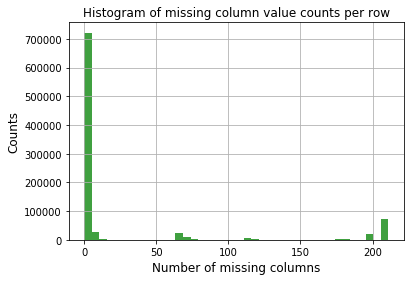

In [25]:
null_row_counts = azdias_sel_cols.isnull().sum(axis=1)
null_row_counts.values

plt.hist(null_row_counts.values, bins=40, facecolor='g', alpha=0.75)

plt.xlabel('Number of missing columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of missing column value counts per row', fontsize=12)
plt.grid(True)
plt.show()

In [26]:
print(len(final_column_list))
azdias_sel_cols.info(verbose=True)

265
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 265 columns):
D19_BANKEN_ANZ_24              int64
KBA05_SEG4                     float64
WOHNLAGE                       float64
D19_GESAMT_ONLINE_DATUM        int64
D19_BANKEN_DATUM               int64
KBA05_SEG5                     float64
KBA13_SEG_KOMPAKTKLASSE        float64
GEBURTSJAHR                    int64
KBA13_SEG_VAN                  float64
KBA05_CCM2                     float64
HEALTH_TYP                     float64
KBA13_SITZE_4                  float64
GFK_URLAUBERTYP                float64
KBA05_HERST1                   float64
D19_GESAMT_DATUM               int64
KBA05_CCM1                     float64
KBA13_CCM_2501                 float64
REGIOTYP                       float64
KBA13_CCM_1000                 float64
D19_GESAMT_ANZ_12              int64
KBA05_DIESEL                   float64
KBA05_SEG10                    float64
KBA13_VORB_3                   float64

In [27]:
# It is clear from the above that most of the rows have less than 10 missing values across columns per row.
# Hence it might be a good idea to only consider rows whose where the number of missing col values <= 20
print(azdias_sel_cols.shape)
azdias_sel_cols = azdias_sel_cols.dropna(thresh=len(azdias_sel_cols.columns)-10)
azdias_sel_cols.shape

(891221, 265)


(749990, 265)

In [28]:
azdias_sel_cols.columns

Index(['D19_BANKEN_ANZ_24', 'KBA05_SEG4', 'WOHNLAGE',
       'D19_GESAMT_ONLINE_DATUM', 'D19_BANKEN_DATUM', 'KBA05_SEG5',
       'KBA13_SEG_KOMPAKTKLASSE', 'GEBURTSJAHR', 'KBA13_SEG_VAN', 'KBA05_CCM2',
       ...
       'WOHNDAUER_2008', 'SEMIO_MAT', 'KBA05_FRAU', 'KBA13_KMH_0_140',
       'FINANZTYP', 'D19_GESAMT_ANZ_24', 'KBA05_MAXVORB', 'LP_STATUS_GROB',
       'KBA05_ANTG3', 'KBA13_KW_40'],
      dtype='object', length=265)

In [29]:
# This is no longer required.. since making the categorical columns as Category type, takes care
# Look at columns of object data type to understand what kind of data it contains
# Look at the catgeory type columns to understand if they are multi-categories of binary categories
azdias_sel_cols.columns.to_series().groupby(azdias_sel_cols.dtypes).groups
# azdias_sel_cols.columns.groupby('dtype').keys # .to_series().groupby()


{dtype('int64'): Index(['D19_BANKEN_ANZ_24', 'D19_GESAMT_ONLINE_DATUM', 'D19_BANKEN_DATUM',
        'GEBURTSJAHR', 'D19_GESAMT_DATUM', 'D19_GESAMT_ANZ_12', 'FINANZ_SPARER',
        'SEMIO_FAM', 'ALTERSKATEGORIE_GROB', 'SEMIO_KRIT',
        'D19_TELKO_OFFLINE_DATUM', 'D19_VERSI_ANZ_24', 'ZABEOTYP',
        'FINANZ_UNAUFFAELLIGER', 'SEMIO_LUST', 'D19_VERSI_ANZ_12', 'SEMIO_KULT',
        'FINANZ_HAUSBAUER', 'D19_VERSAND_OFFLINE_DATUM', 'FINANZ_VORSORGER',
        'D19_TELKO_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'ANREDE_KZ',
        'D19_VERSAND_ANZ_12', 'D19_TELKO_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'SEMIO_ERL', 'SEMIO_VERT', 'SEMIO_DOM', 'D19_VERSAND_DATUM',
        'D19_TELKO_ANZ_12', 'D19_BANKEN_ANZ_12', 'GREEN_AVANTGARDE',
        'SEMIO_REL', 'SEMIO_TRADV', 'D19_GESAMT_OFFLINE_DATUM', 'SEMIO_KAEM',
        'SEMIO_SOZ', 'D19_VERSAND_ANZ_24', 'D19_TELKO_ANZ_24',
        'D19_BANKEN_ONLINE_DATUM', 'SEMIO_PFLICHT', 'FINANZ_MINIMALIST',
        'D19_BANKEN_OFFLINE_DATUM', 'SEMIO_RAT', 

In [30]:
# investigate if any of the cateforical columns contains any datetime or any such values
# for colname in ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
#     print("{} = {}".format(colname, azdias_sel_cols[colname].unique()))

In [31]:
object_type_columns = ['OST_WEST_KZ', 'CAMEO_DEU_2015']
azdias_sel_cols[object_type_columns].isnull().sum()

OST_WEST_KZ          0
CAMEO_DEU_2015    3551
dtype: int64

In [32]:
# instead of using a complex process of label encoding the null values for categorical columns, 
# and then removing it etc. 
# since only a small fraction of rows are involved here.. we'll drop these rows
# TBD: This will need to change, because as a result of dropping these rows... 
# some other categorical values might get dropped totally.. and thereby impacting lableencoding later on

azdias_sel_cols.dropna(axis=0, subset=object_type_columns, inplace=True)
print(azdias_sel_cols.OST_WEST_KZ.unique())
azdias_sel_cols[object_type_columns].isnull().sum()

['W' 'O']


OST_WEST_KZ       0
CAMEO_DEU_2015    0
dtype: int64

In [33]:
# now use label encoder to encode the object type labels
# import labelencoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
# # instantiate labelencoder object
# le = LabelEncoder()

# apply le on categorical feature columns
# azdias_sel_cols[object_type_columns] = (azdias_sel_cols[object_type_columns]).astype(str).apply(lambda col: le.fit_transform(col))

azdias_sel_cols[object_type_columns] = azdias_sel_cols[object_type_columns].astype(str).apply(lambda x: d[x.name].fit_transform(x))
# labeled_df = df.apply(lambda x: encoder_dict[x.name].fit_transform(x))

In [34]:
d

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'OST_WEST_KZ': LabelEncoder(), 'CAMEO_DEU_2015': LabelEncoder()})

In [35]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')

In [36]:
azdias_sel_cols_filled = imputer.fit_transform(azdias_sel_cols)

azdias_sel_cols_filled

array([[0., 2., 4., ..., 1., 0., 2.],
       [0., 3., 2., ..., 2., 1., 1.],
       [0., 3., 7., ..., 4., 0., 4.],
       ...,
       [0., 4., 7., ..., 2., 1., 3.],
       [0., 3., 5., ..., 1., 2., 1.],
       [0., 3., 4., ..., 1., 1., 3.]])

In [37]:
azdias_sel_cols_filled.shape

(746439, 265)

In [38]:
azdias_sel_cols_filled = pd.DataFrame(azdias_sel_cols_filled, columns = azdias_sel_cols.columns)
print(azdias_sel_cols_filled.isnull().sum().sort_values())
azdias_sel_cols_filled.describe()
print(azdias_sel_cols_filled.shape)

D19_BANKEN_ANZ_24              0
PLZ8_ANTG4                     0
PLZ8_HHZ                       0
ALTER_HH                       0
SEMIO_DOM                      0
KBA13_SEG_MITTELKLASSE         0
KBA13_CCM_3000                 0
KBA13_HALTER_50                0
KBA05_ALTER1                   0
CAMEO_DEU_2015                 0
KBA13_MERCEDES                 0
D19_VERSAND_DATUM              0
D19_TELKO_ANZ_12               0
KBA13_NISSAN                   0
KBA13_KW_61_120                0
KBA05_MOD8                     0
KBA05_KRSVAN                   0
KBA13_FIAT                     0
KBA13_KW_80                    0
KBA05_HERST4                   0
D19_BANKEN_ANZ_12              0
KBA13_BJ_2000                  0
KBA13_KW_121                   0
GREEN_AVANTGARDE               0
SEMIO_REL                      0
SEMIO_TRADV                    0
KBA05_MOTOR                    0
PLZ8_ANTG1                     0
D19_GESAMT_OFFLINE_DATUM       0
KBA13_HALTER_65                0
KBA13_VORB

(746439, 265)


In [39]:
# before applying get_dummies... convert the categorical columns to categorical type... 
# so that values not present also get a column of their own
common_category_columns = list(set(category_columns).intersection(set(azdias_sel_cols_filled.columns)))
for colname in category_columns:
    print(categorical_dict[colname])
    azdias_sel_cols_filled[colname] = pd.Categorical(azdias_sel_cols_filled[colname], categories = categorical_dict[colname].categories)

[1, 2]
Categories (2, int64): [1, 2]
[1A, 1B, 1C, 1D, 1E, ..., 9A, 9B, 9C, 9D, 9E]
Length: 44
Categories (44, object): [1A, 1B, 1C, 1D, ..., 9B, 9C, 9D, 9E]
[1, 2, 3, 4, 5, 6]
Categories (6, int64): [1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Categor

In [40]:
# df_final = azdias_sel_cols_filled.copy()
# for colname in category_columns:
df_final = pd.get_dummies(azdias_sel_cols_filled, columns=category_columns, prefix=category_columns)
df_final.head()

,D19_BANKEN_ANZ_24,KBA05_SEG4,WOHNLAGE,KBA05_SEG5,KBA13_SEG_KOMPAKTKLASSE,GEBURTSJAHR,KBA13_SEG_VAN,KBA05_CCM2,KBA13_SITZE_4,KBA05_HERST1,KBA05_CCM1,KBA13_CCM_2501,REGIOTYP,KBA13_CCM_1000,D19_GESAMT_ANZ_12,KBA05_DIESEL,KBA05_SEG10,KBA13_VORB_3,FINANZ_SPARER,KBA13_HERST_BMW_BENZ,SEMIO_FAM,KBA05_ZUL2,KBA13_KW_120,KBA05_ZUL3,KBA13_KMH_140_210,KBA13_CCM_0_1400,ALTERSKATEGORIE_GROB,KBA13_MAZDA,KBA13_SEG_SPORTWAGEN,SEMIO_KRIT,KBA13_FORD,KBA13_HALTER_45,KBA13_SEG_SONSTIGE,KBA05_ZUL1,KBA05_KRSZUL,KBA13_FAB_ASIEN,KBA13_KRSZUL_NEU,KBA05_SEG1,ORTSGR_KLS9,KBA13_SEG_WOHNMOBILE,KBA13_VORB_2,KBA05_KW1,KBA13_BJ_2008,D19_VERSI_ANZ_24,KBA13_CCM_1500,KBA13_KW_90,KBA05_HERST5,KBA05_KW2,KBA13_KW_30,FINANZ_UNAUFFAELLIGER,LP_FAMILIE_GROB,SEMIO_LUST,KBA05_MAXBJ,KBA05_KRSKLEIN,D19_VERSI_ANZ_12,KKK,KBA05_MOD1,KBA13_HERST_FORD_OPEL,SEMIO_KULT,KBA13_KMH_180,KBA05_ALTER4,ONLINE_AFFINITAET,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_BAUMAX,KBA13_HERST_SONST,FINANZ_VORSORGER,PLZ8_ANTG2,KBA13_KW_50,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,KBA05_HERSTTEMP,KBA13_KRSAQUOT,KBA05_HERST3,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA13_ALTERHALTER_60,INNENSTADT,KBA05_MOD3,KBA13_KW_0_60,KBA05_KRSOBER,PLZ8_BAUMAX,KONSUMNAEHE,KBA13_CCM_1800,KBA13_KRSSEG_OBER,KBA13_SEG_MINIWAGEN,KBA05_VORB1,EWDICHTE,KBA13_SEG_KLEINST,KBA05_SEG3,KBA13_HERST_AUDI_VW,KBA13_HALTER_60,KBA13_KMH_140,KBA13_CCM_1400,KBA13_SEG_OBERKLASSE,KBA05_KRSHERST3,ANZ_PERSONEN,KBA05_MOD4,KBA13_CCM_3001,KBA13_ALTERHALTER_45,KBA13_KW_110,D19_VERSAND_ANZ_12,KBA13_HALTER_66,KBA13_CCM_1600,KBA13_SEG_MINIVANS,KBA13_VORB_0,ANZ_TITEL,KBA13_RENAULT,KBA13_SEG_KLEINWAGEN,KBA13_KMH_110,KBA05_SEG7,KBA05_VORB0,RELAT_AB,KBA13_CCM_2500,W_KEIT_KIND_HH,KBA05_KRSHERST2,BALLRAUM,KBA05_MAXAH,KBA05_ALTER3,KBA13_KW_70,KBA05_ANTG4,KBA05_KW3,KBA13_FAB_SONSTIGE,KBA05_ALTER2,KBA13_HALTER_25,KBA13_HALTER_55,KBA13_KMH_251,FINANZ_ANLEGER,KBA13_KW_60,KBA13_SEG_UTILITIES,KBA13_HALTER_40,KBA13_BMW,KBA05_SEG2,HH_EINKOMMEN_SCORE,SEMIO_ERL,KBA13_CCM_1200,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_ALTERHALTER_61,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,KBA13_KRSSEG_VAN,KBA13_SITZE_5,KBA13_VORB_1,PLZ8_ANTG4,PLZ8_HHZ,ALTER_HH,SEMIO_DOM,KBA13_SEG_MITTELKLASSE,KBA13_CCM_3000,KBA13_HALTER_50,KBA05_ALTER1,KBA13_MERCEDES,KBA13_NISSAN,KBA13_KW_61_120,KBA05_MOD8,KBA05_KRSVAN,KBA13_FIAT,KBA13_KW_80,KBA05_HERST4,D19_BANKEN_ANZ_12,KBA13_BJ_2000,KBA13_KW_121,SEMIO_REL,SEMIO_TRADV,PLZ8_ANTG1,KBA13_HALTER_65,KBA13_KRSHERST_AUDI_VW,KBA13_OPEL,MOBI_REGIO,KBA13_BJ_1999,KBA05_ZUL4,KBA13_SEG_GROSSRAUMVANS,KBA13_PEUGEOT,SEMIO_KAEM,KBA05_HERST2,SEMIO_SOZ,KBA13_SITZE_6,MIN_GEBAEUDEJAHR,KBA13_VW,KBA13_BJ_2004,KBA05_VORB2,KBA13_HALTER_30,KBA13_BJ_2006,KBA05_CCM4,KBA13_VORB_1_2,D19_VERSAND_ANZ_24,KBA05_SEG6,KBA05_GBZ,KBA13_BJ_2009,KBA13_CCM_2000,PLZ8_ANTG3,PLZ8_GBZ,KBA05_ANTG2,KBA05_MOD2,KBA05_CCM3,ANZ_HH_TITEL,KBA13_KMH_250,KBA13_AUDI,KBA13_KRSHERST_FORD_OPEL,KBA13_HALTER_20,KBA05_SEG9,SEMIO_PFLICHT,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MOTRAD,KBA13_HALTER_35,KBA13_MOTOR,KBA13_HERST_EUROPA,KBA05_KRSAQUOT,FINANZ_MINIMALIST,KBA05_AUTOQUOT,KBA13_ALTERHALTER_30,KBA13_KRSSEG_KLEIN,SEMIO_RAT,KBA13_AUTOQUOTE,KBA05_SEG8,KBA13_KMH_211,KBA05_KRSHERST1,WOHNDAUER_2008,SEMIO_MAT,KBA05_FRAU,KBA13_KMH_0_140,D19_GESAMT_ANZ_24,LP_STATUS_GROB,KBA05_ANTG3,KBA13_KW_40,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAM

In [41]:
# Let's make sure one final time time that there are no null values left
print(sum(df_final.isnull().sum()))
print(df_final.shape)

0
(746439, 580)


In [42]:
# apply scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_scaled = scaler.fit_transform(df_final)
df_final_scaled = pd.DataFrame(df_final_scaled, columns= list(df_final.columns.values))
df_final_scaled.head()

,D19_BANKEN_ANZ_24,KBA05_SEG4,WOHNLAGE,KBA05_SEG5,KBA13_SEG_KOMPAKTKLASSE,GEBURTSJAHR,KBA13_SEG_VAN,KBA05_CCM2,KBA13_SITZE_4,KBA05_HERST1,KBA05_CCM1,KBA13_CCM_2501,REGIOTYP,KBA13_CCM_1000,D19_GESAMT_ANZ_12,KBA05_DIESEL,KBA05_SEG10,KBA13_VORB_3,FINANZ_SPARER,KBA13_HERST_BMW_BENZ,SEMIO_FAM,KBA05_ZUL2,KBA13_KW_120,KBA05_ZUL3,KBA13_KMH_140_210,KBA13_CCM_0_1400,ALTERSKATEGORIE_GROB,KBA13_MAZDA,KBA13_SEG_SPORTWAGEN,SEMIO_KRIT,KBA13_FORD,KBA13_HALTER_45,KBA13_SEG_SONSTIGE,KBA05_ZUL1,KBA05_KRSZUL,KBA13_FAB_ASIEN,KBA13_KRSZUL_NEU,KBA05_SEG1,ORTSGR_KLS9,KBA13_SEG_WOHNMOBILE,KBA13_VORB_2,KBA05_KW1,KBA13_BJ_2008,D19_VERSI_ANZ_24,KBA13_CCM_1500,KBA13_KW_90,KBA05_HERST5,KBA05_KW2,KBA13_KW_30,FINANZ_UNAUFFAELLIGER,LP_FAMILIE_GROB,SEMIO_LUST,KBA05_MAXBJ,KBA05_KRSKLEIN,D19_VERSI_ANZ_12,KKK,KBA05_MOD1,KBA13_HERST_FORD_OPEL,SEMIO_KULT,KBA13_KMH_180,KBA05_ALTER4,ONLINE_AFFINITAET,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_BAUMAX,KBA13_HERST_SONST,FINANZ_VORSORGER,PLZ8_ANTG2,KBA13_KW_50,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,KBA05_HERSTTEMP,KBA13_KRSAQUOT,KBA05_HERST3,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA13_ALTERHALTER_60,INNENSTADT,KBA05_MOD3,KBA13_KW_0_60,KBA05_KRSOBER,PLZ8_BAUMAX,KONSUMNAEHE,KBA13_CCM_1800,KBA13_KRSSEG_OBER,KBA13_SEG_MINIWAGEN,KBA05_VORB1,EWDICHTE,KBA13_SEG_KLEINST,KBA05_SEG3,KBA13_HERST_AUDI_VW,KBA13_HALTER_60,KBA13_KMH_140,KBA13_CCM_1400,KBA13_SEG_OBERKLASSE,KBA05_KRSHERST3,ANZ_PERSONEN,KBA05_MOD4,KBA13_CCM_3001,KBA13_ALTERHALTER_45,KBA13_KW_110,D19_VERSAND_ANZ_12,KBA13_HALTER_66,KBA13_CCM_1600,KBA13_SEG_MINIVANS,KBA13_VORB_0,ANZ_TITEL,KBA13_RENAULT,KBA13_SEG_KLEINWAGEN,KBA13_KMH_110,KBA05_SEG7,KBA05_VORB0,RELAT_AB,KBA13_CCM_2500,W_KEIT_KIND_HH,KBA05_KRSHERST2,BALLRAUM,KBA05_MAXAH,KBA05_ALTER3,KBA13_KW_70,KBA05_ANTG4,KBA05_KW3,KBA13_FAB_SONSTIGE,KBA05_ALTER2,KBA13_HALTER_25,KBA13_HALTER_55,KBA13_KMH_251,FINANZ_ANLEGER,KBA13_KW_60,KBA13_SEG_UTILITIES,KBA13_HALTER_40,KBA13_BMW,KBA05_SEG2,HH_EINKOMMEN_SCORE,SEMIO_ERL,KBA13_CCM_1200,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_ALTERHALTER_61,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,KBA13_KRSSEG_VAN,KBA13_SITZE_5,KBA13_VORB_1,PLZ8_ANTG4,PLZ8_HHZ,ALTER_HH,SEMIO_DOM,KBA13_SEG_MITTELKLASSE,KBA13_CCM_3000,KBA13_HALTER_50,KBA05_ALTER1,KBA13_MERCEDES,KBA13_NISSAN,KBA13_KW_61_120,KBA05_MOD8,KBA05_KRSVAN,KBA13_FIAT,KBA13_KW_80,KBA05_HERST4,D19_BANKEN_ANZ_12,KBA13_BJ_2000,KBA13_KW_121,SEMIO_REL,SEMIO_TRADV,PLZ8_ANTG1,KBA13_HALTER_65,KBA13_KRSHERST_AUDI_VW,KBA13_OPEL,MOBI_REGIO,KBA13_BJ_1999,KBA05_ZUL4,KBA13_SEG_GROSSRAUMVANS,KBA13_PEUGEOT,SEMIO_KAEM,KBA05_HERST2,SEMIO_SOZ,KBA13_SITZE_6,MIN_GEBAEUDEJAHR,KBA13_VW,KBA13_BJ_2004,KBA05_VORB2,KBA13_HALTER_30,KBA13_BJ_2006,KBA05_CCM4,KBA13_VORB_1_2,D19_VERSAND_ANZ_24,KBA05_SEG6,KBA05_GBZ,KBA13_BJ_2009,KBA13_CCM_2000,PLZ8_ANTG3,PLZ8_GBZ,KBA05_ANTG2,KBA05_MOD2,KBA05_CCM3,ANZ_HH_TITEL,KBA13_KMH_250,KBA13_AUDI,KBA13_KRSHERST_FORD_OPEL,KBA13_HALTER_20,KBA05_SEG9,SEMIO_PFLICHT,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MOTRAD,KBA13_HALTER_35,KBA13_MOTOR,KBA13_HERST_EUROPA,KBA05_KRSAQUOT,FINANZ_MINIMALIST,KBA05_AUTOQUOT,KBA13_ALTERHALTER_30,KBA13_KRSSEG_KLEIN,SEMIO_RAT,KBA13_AUTOQUOTE,KBA05_SEG8,KBA13_KMH_211,KBA05_KRSHERST1,WOHNDAUER_2008,SEMIO_MAT,KBA05_FRAU,KBA13_KMH_0_140,D19_GESAMT_ANZ_24,LP_STATUS_GROB,KBA05_ANTG3,KBA13_KW_40,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAM

In [43]:
list(final_column_list)

['D19_BANKEN_ANZ_24',
 'KBA05_SEG4',
 'WOHNLAGE',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_BANKEN_DATUM',
 'KBA05_SEG5',
 'KBA13_SEG_KOMPAKTKLASSE',
 'GEBURTSJAHR',
 'KBA13_SEG_VAN',
 'KBA05_CCM2',
 'HEALTH_TYP',
 'KBA13_SITZE_4',
 'GFK_URLAUBERTYP',
 'KBA05_HERST1',
 'D19_GESAMT_DATUM',
 'KBA05_CCM1',
 'KBA13_CCM_2501',
 'REGIOTYP',
 'KBA13_CCM_1000',
 'D19_GESAMT_ANZ_12',
 'KBA05_DIESEL',
 'KBA05_SEG10',
 'KBA13_VORB_3',
 'FINANZ_SPARER',
 'KBA13_HERST_BMW_BENZ',
 'SEMIO_FAM',
 'KBA05_ZUL2',
 'KBA13_KW_120',
 'KBA05_ZUL3',
 'KBA13_KMH_140_210',
 'KBA13_CCM_0_1400',
 'ALTERSKATEGORIE_GROB',
 'KBA13_MAZDA',
 'KBA13_SEG_SPORTWAGEN',
 'SEMIO_KRIT',
 'KBA13_FORD',
 'KBA13_HALTER_45',
 'KBA13_SEG_SONSTIGE',
 'KBA05_ZUL1',
 'KBA05_KRSZUL',
 'KBA13_FAB_ASIEN',
 'KBA13_KRSZUL_NEU',
 'LP_FAMILIE_FEIN',
 'KBA05_SEG1',
 'ORTSGR_KLS9',
 'KBA13_SEG_WOHNMOBILE',
 'KBA13_VORB_2',
 'KBA05_KW1',
 'KBA13_BJ_2008',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_VERSI_ANZ_24',
 'KBA13_CCM_1500',
 'KBA13_KW_90',
 'PRAEGENDE_

In [44]:
### Based on the data clean and transformation etc., create a function to prepare data for clustering etc.
def clean_prepare_data(df):

    # Replace unknowns with null
    df, dict_cats = mark_invalid_values_as_null(df)
    df = mark_unknown_as_null(df)
    
    # 1. First of all drop all the columns that are either not part of the attributes list or had too many null values
    df = df[list(final_column_list)]
    print(len(df.columns))
    
    # 2. Delete all rows that have more than 10 columns with null values
    df = df.dropna(thresh=len(df.columns)-10)

    
    # 2. Delete all rows with object type data, with null values
    df = df.dropna(axis=0, subset=object_type_columns)
    print(len(df.columns))
    
    # 3. Use the previous Label encoder to encode the categorical columns
    df[object_type_columns] = df[object_type_columns].astype(str).apply(lambda x: d[x.name].fit_transform(x))
    print(len(df.columns))

    # 4. Use the prevous fitted imputer to fillna
    imputed_data = imputer.transform(df)
    df = pd.DataFrame(imputed_data, columns = df.columns)
    print(len(df.columns))

#     df[category_columns] = df[category_columns].astype(int)
#     print('converted all categorical columns to integer type')

    common_category_columns = list(set(category_columns).intersection(set(df.columns)))
    for colname in common_category_columns:
        df[colname] = pd.Categorical(df[colname], categories = categorical_dict[colname].categories)
    
    # 5. Use the hotencoding to transform cateorical rows to columns
    df = pd.get_dummies(df, columns=category_columns, prefix=category_columns)
    print(len(df.columns))
    
    # 6. Apply the previously fitted scaler
#     df = scaler.transform(df)
    
    # return the final dataset
    return df

In [45]:
# release unwanted variables holding large datasets
# del df_final
# del azdias_sel_cols_filled
# del azdias_sel_cols

import gc
gc.collect()

8990

In [46]:
azdias[final_column_list].head()

,D19_BANKEN_ANZ_24,KBA05_SEG4,WOHNLAGE,D19_GESAMT_ONLINE_DATUM,D19_BANKEN_DATUM,KBA05_SEG5,KBA13_SEG_KOMPAKTKLASSE,GEBURTSJAHR,KBA13_SEG_VAN,KBA05_CCM2,HEALTH_TYP,KBA13_SITZE_4,GFK_URLAUBERTYP,KBA05_HERST1,D19_GESAMT_DATUM,KBA05_CCM1,KBA13_CCM_2501,REGIOTYP,KBA13_CCM_1000,D19_GESAMT_ANZ_12,KBA05_DIESEL,KBA05_SEG10,KBA13_VORB_3,FINANZ_SPARER,KBA13_HERST_BMW_BENZ,SEMIO_FAM,KBA05_ZUL2,KBA13_KW_120,KBA05_ZUL3,KBA13_KMH_140_210,KBA13_CCM_0_1400,ALTERSKATEGORIE_GROB,KBA13_MAZDA,KBA13_SEG_SPORTWAGEN,SEMIO_KRIT,KBA13_FORD,KBA13_HALTER_45,KBA13_SEG_SONSTIGE,KBA05_ZUL1,KBA05_KRSZUL,KBA13_FAB_ASIEN,KBA13_KRSZUL_NEU,LP_FAMILIE_FEIN,KBA05_SEG1,ORTSGR_KLS9,KBA13_SEG_WOHNMOBILE,KBA13_VORB_2,KBA05_KW1,KBA13_BJ_2008,D19_TELKO_OFFLINE_DATUM,D19_VERSI_ANZ_24,KBA13_CCM_1500,KBA13_KW_90,PRAEGENDE_JUGENDJAHRE,KBA05_HERST5,KBA05_KW2,ZABEOTYP,LP_STATUS_FEIN,KBA13_KW_30,FINANZ_UNAUFFAELLIGER,LP_FAMILIE_GROB,SEMIO_LUST,KBA05_MAXSEG,KBA05_MAXBJ,KBA05_KRSKLEIN,D19_VERSI_ANZ_12,KKK,KBA05_MOD1,KBA13_HERST_FORD_OPEL,SEMIO_KULT,KBA13_KMH_180,KBA05_ALTER4,ONLINE_AFFINITAET,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_BAUMAX,KBA13_HERST_SONST,VERS_TYP,D19_VERSAND_OFFLINE_DATUM,FINANZ_VORSORGER,PLZ8_ANTG2,KBA13_KW_50,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,KBA05_HERSTTEMP,KBA13_KRSAQUOT,KBA05_HERST3,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,GEBAEUDETYP,KBA13_ALTERHALTER_60,INNENSTADT,KBA05_MOD3,KBA13_KW_0_60,KBA05_KRSOBER,PLZ8_BAUMAX,KONSUMNAEHE,KBA13_CCM_1800,KBA13_KRSSEG_OBER,KBA13_SEG_MINIWAGEN,KBA05_VORB1,D19_TELKO_DATUM,EWDICHTE,KBA13_SEG_KLEINST,KBA05_SEG3,KBA13_HERST_AUDI_VW,KBA13_HALTER_60,KBA13_KMH_140,NATIONALITAET_KZ,D19_VERSAND_ONLINE_DATUM,ANREDE_KZ,KBA13_CCM_1400,KBA13_SEG_OBERKLASSE,LP_LEBENSPHASE_GROB,KBA05_KRSHERST3,ANZ_PERSONEN,KBA05_MOD4,KBA13_CCM_3001,KBA13_ALTERHALTER_45,KBA13_KW_110,D19_VERSAND_ANZ_12,KBA13_HALTER_66,KBA13_CCM_1600,KBA13_SEG_MINIVANS,KBA13_VORB_0,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,ANZ_TITEL,KBA13_RENAULT,KBA13_SEG_KLEINWAGEN,KBA13_KMH_110,KBA05_SEG7,KBA05_VORB0,RELAT_AB,KBA13_CCM_2500,W_KEIT_KIND_HH,KBA05_KRSHERST2,BALLRAUM,KBA05_MAXAH,KBA05_ALTER3,KBA13_KW_70,D19_TELKO_ONLINE_DATUM,KBA05_ANTG4,KBA05_KW3,KBA13_FAB_SONSTIGE,KBA05_MODTEMP,KBA05_ALTER2,KBA13_HALTER_25,KBA13_HALTER_55,KBA13_KMH_251,FINANZ_ANLEGER,KBA13_KW_60,KBA13_SEG_UTILITIES,KBA13_HALTER_40,KBA13_BMW,KBA05_SEG2,HH_EINKOMMEN_SCORE,SEMIO_ERL,KBA13_CCM_1200,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_ALTERHALTER_61,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,KBA13_KRSSEG_VAN,KBA13_SITZE_5,KBA13_VORB_1,PLZ8_ANTG4,PLZ8_HHZ,ALTER_HH,SEMIO_DOM,KBA13_SEG_MITTELKLASSE,KBA13_CCM_3000,KBA13_HALTER_50,KBA05_ALTER1,CAMEO_DEU_2015,KBA13_MERCEDES,D19_VERSAND_DATUM,D19_TELKO_ANZ_12,KBA13_NISSAN,KBA13_KW_61_120,KBA05_MOD8,KBA05_KRSVAN,KBA13_FIAT,KBA13_KW_80,KBA05_HERST4,D19_BANKEN_ANZ_12,KBA13_BJ_2000,KBA13_KW_121,GREEN_AVANTGARDE,SEMIO_REL,SEMIO_TRADV,KBA05_MOTOR,PLZ8_ANTG1,D19_GESAMT_OFFLINE_DATUM,KBA13_HALTER_65,KBA13_KRSHERST_AUDI_VW,KBA13_OPEL,MOBI_REGIO,KBA13_BJ_1999,KBA05_ZUL4,KBA13_SEG_GROSSRAUMVANS,KBA13_PEUGEOT,SEMIO_KAEM,KBA05_HERST2,SEMIO_SOZ,KBA13_SITZE_6,MIN_GEBAEUDEJAHR,KBA13_VW,KBA13_BJ_2004,KBA05_VORB2,KBA13_HALTER_30,KBA13_BJ_2006,KBA05_CCM4,KBA13_VORB_1_2,D19_VERSAND_ANZ_24,KBA05_SEG6,KBA05_GBZ,KBA13_BJ_2009,KBA13_CCM_2000,PLZ8_ANTG3,PLZ8_GBZ,KBA05_ANTG2,D19_TELKO_ANZ_24,CJT_GESAMTTYP,KBA05_MOD2,KBA05_CCM3,ANZ_HH_TITEL,KBA13_KMH_250,KBA13_AUDI,KBA13_KRSHERST_FORD_OPEL,D19_BANKEN_ONLINE_DATUM,KBA13_HALTER_20,KBA05_SEG9,SEMIO_PFLICHT,GEBAEUDETYP_RASTER,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MOTRAD,KBA13_HALTER_35,KBA13_MOTOR,OST_WEST_KZ,KBA13_HERST_EUROPA,KBA05_KRSAQUOT,FINANZ_MINIMALIST,KBA05_AUTOQUOT,KBA13_ALTERHALTER_30,D19_BANKEN_OFFLINE_DATUM,SHOPPER_TYP,KBA13_KRSSEG_KLEIN,SEMIO_RAT,KBA13_AUTOQUOTE,KBA05_SEG8,KBA05_MAXHERST,KBA13_KMH_211,KBA05_KRSHERST1,WOHNDAUER_2008,SEMIO_MAT,KBA05_FRAU,KBA13_KMH_0_140,FINANZTYP,D19_GESAMT_ANZ_24,KBA05_MAXVORB,LP_STATUS_GROB,KBA05_ANTG3,KBA13_KW_40
0,0,NaN,NaN,10,10,NaN,NaN,0,NaN,NaN,-1,NaN,10.0,NaN,10,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,4,NaN,6,NaN,NaN,NaN,NaN

In [47]:
df = clean_prepare_data(azdias)

Numerical
Numerical
Numerical
Category
D19_GESAMT_ONLINE_DATUM
valid values for column:D19_GESAMT_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
891221
Category
D19_BANKEN_DATUM
valid values for column:D19_BANKEN_DATUM, are [1 2 3 4 5 6 7 8 9 10]
891221
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
HEALTH_TYP
valid values for column:HEALTH_TYP, are [0 1 2 3]
780025
Numerical
Category
GFK_URLAUBERTYP
valid values for column:GFK_URLAUBERTYP, are [1 2 3 4 5 6 7 8 9 10 11 12]
886367
Numerical
Category
D19_GESAMT_DATUM
valid values for column:D19_GESAMT_DATUM, are [1 2 3 4 5 6 7 8 9 10]
891221
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
CAMEO_DEUG_2015
valid values for column:CAMEO_DEUG_2015, are [1 2 3 4 5 6 7 8 9]
332884
Numerical
Numerical
Numerical
Category
LP_FAMILIE_

In [48]:
print(df.shape)
print(df_final_scaled.shape)
# transfomed_columns = df_final_scaled.columns
# df = df[transfomed_columns]
print(df.shape)

(746439, 580)
(746439, 580)
(746439, 580)


In [49]:
# print(set(df.columns)-(set(df_final_scaled.columns)))

In [50]:
df_final_scaled.columns.sort_values()

Index(['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ_1', 'ANREDE_KZ_2',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'BALLRAUM', 'CAMEO_DEU_2015_1A',
       ...
       'VERS_TYP_2', 'WOHNDAUER_2008', 'WOHNLAGE', 'W_KEIT_KIND_HH',
       'ZABEOTYP_1', 'ZABEOTYP_2', 'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5',
       'ZABEOTYP_6'],
      dtype='object', length=580)

In [51]:
# make sure that the above data preparation on customer dataset will leave us with the same columns and enough rows
df_customers = clean_prepare_data(customers)


Numerical
Numerical
Numerical
Category
D19_GESAMT_ONLINE_DATUM
valid values for column:D19_GESAMT_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
191652
Category
D19_BANKEN_DATUM
valid values for column:D19_BANKEN_DATUM, are [1 2 3 4 5 6 7 8 9 10]
191652
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
HEALTH_TYP
valid values for column:HEALTH_TYP, are [0 1 2 3]
142662
Numerical
Category
GFK_URLAUBERTYP
valid values for column:GFK_URLAUBERTYP, are [1 2 3 4 5 6 7 8 9 10 11 12]
188439
Numerical
Category
D19_GESAMT_DATUM
valid values for column:D19_GESAMT_DATUM, are [1 2 3 4 5 6 7 8 9 10]
191652
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
CAMEO_DEUG_2015
valid values for column:CAMEO_DEUG_2015, are [1 2 3 4 5 6 7 8 9]
36026
Numerical
Numerical
Numerical
Category
LP_FAMILIE_F

In [52]:
print(df_customers.shape)

(134646, 580)


In [53]:
print(set(df.columns).difference(set(df_customers.columns)))

set()


In [54]:
set(azdias.columns).difference(set(customers.columns))
print(customers.GEBAEUDETYP.unique())
# print(df_customers.GEBAEUDETYP.unique())

[ 1. nan  8.  2.  3.  4.  6.]


In [55]:

# use PCA for analysis and dimensionality reduction
from sklearn.decomposition import PCA

# let's create a reusable function to execute PCA on data to a stated n number of components
# because we'll need to experiment with different number of PCA components
def do_pca(data, n):
    pca = PCA(n_components=n, random_state=1)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [56]:
# Let's reduce the component by half and see how the explained variance varies with the number of components
# Total number of dimensions currently is 600.. so let's do PCA with 300 components
pca, X_pca = do_pca(df_final_scaled, 300)

In [57]:
len(pca.explained_variance_)

300

In [58]:
## Let's plot how the variance varies with the number of components of PCA
# to decide an appropriate number of components to choose.
# We will try to get preserve at least 805 of the variance
def plot_variance(pca):
    num_components=len(pca.explained_variance_ratio_)
    num_components = np.arange(num_components)
    ratios = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(ratios)
    ax.bar(num_components, ratios)
    ax.plot(num_components, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

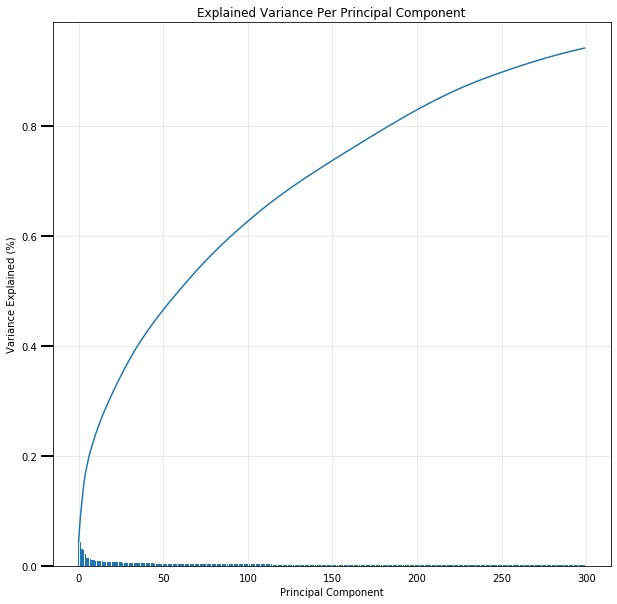

In [59]:
plot_variance(pca)

In [60]:
# we see from the above that roughly 150 of the components explain around 65% of the variance
# also the variance explained does not increase at a high rate with the increase in the number of components beyond 150
# Hence let's now reduce the number of PCA components to 150 and get those components
pca_150, X_pca_150 = do_pca(df_final_scaled, 150)

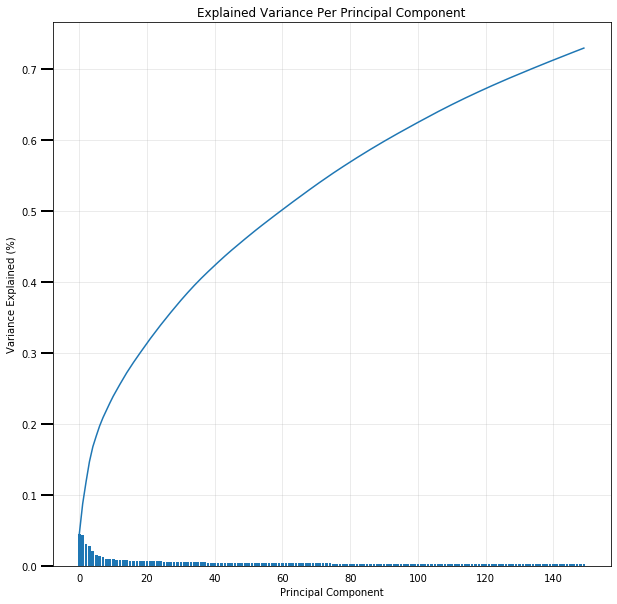

In [61]:
# let's look at the explained variance now to confirm
plot_variance(pca_150)

In [62]:
# now let's look at a few components and map it to the features that contribute the most to those components
pca_150.components_

array([[-0.00051317,  0.11326835,  0.00449851, ..., -0.01254478,
        -0.02299876, -0.0075617 ],
       [-0.05367274,  0.03599654, -0.04010084, ..., -0.00830976,
         0.04129069,  0.03713813],
       [ 0.03607586,  0.02925162,  0.08286673, ...,  0.04287659,
         0.02047559, -0.01278476],
       ...,
       [ 0.00674897, -0.024358  , -0.01841748, ..., -0.02779382,
         0.01725976,  0.01599056],
       [-0.00103207, -0.01207736, -0.02058537, ...,  0.0260001 ,
         0.01695781,  0.01942924],
       [-0.00294878, -0.01684754,  0.04554849, ..., -0.01362757,
        -0.02262832,  0.04159966]])

In [63]:
component_names = ['comp-{}'.format(i) for i in range(1, len(pca_150.components_)+1)]
df_components = pd.DataFrame(pca_150.components_, columns=df_final_scaled.columns, index=component_names)
df_components.head()

,D19_BANKEN_ANZ_24,KBA05_SEG4,WOHNLAGE,KBA05_SEG5,KBA13_SEG_KOMPAKTKLASSE,GEBURTSJAHR,KBA13_SEG_VAN,KBA05_CCM2,KBA13_SITZE_4,KBA05_HERST1,KBA05_CCM1,KBA13_CCM_2501,REGIOTYP,KBA13_CCM_1000,D19_GESAMT_ANZ_12,KBA05_DIESEL,KBA05_SEG10,KBA13_VORB_3,FINANZ_SPARER,KBA13_HERST_BMW_BENZ,SEMIO_FAM,KBA05_ZUL2,KBA13_KW_120,KBA05_ZUL3,KBA13_KMH_140_210,KBA13_CCM_0_1400,ALTERSKATEGORIE_GROB,KBA13_MAZDA,KBA13_SEG_SPORTWAGEN,SEMIO_KRIT,KBA13_FORD,KBA13_HALTER_45,KBA13_SEG_SONSTIGE,KBA05_ZUL1,KBA05_KRSZUL,KBA13_FAB_ASIEN,KBA13_KRSZUL_NEU,KBA05_SEG1,ORTSGR_KLS9,KBA13_SEG_WOHNMOBILE,KBA13_VORB_2,KBA05_KW1,KBA13_BJ_2008,D19_VERSI_ANZ_24,KBA13_CCM_1500,KBA13_KW_90,KBA05_HERST5,KBA05_KW2,KBA13_KW_30,FINANZ_UNAUFFAELLIGER,LP_FAMILIE_GROB,SEMIO_LUST,KBA05_MAXBJ,KBA05_KRSKLEIN,D19_VERSI_ANZ_12,KKK,KBA05_MOD1,KBA13_HERST_FORD_OPEL,SEMIO_KULT,KBA13_KMH_180,KBA05_ALTER4,ONLINE_AFFINITAET,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_BAUMAX,KBA13_HERST_SONST,FINANZ_VORSORGER,PLZ8_ANTG2,KBA13_KW_50,KBA13_SEG_GELAENDEWAGEN,KBA05_ANHANG,KBA05_HERSTTEMP,KBA13_KRSAQUOT,KBA05_HERST3,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA13_ALTERHALTER_60,INNENSTADT,KBA05_MOD3,KBA13_KW_0_60,KBA05_KRSOBER,PLZ8_BAUMAX,KONSUMNAEHE,KBA13_CCM_1800,KBA13_KRSSEG_OBER,KBA13_SEG_MINIWAGEN,KBA05_VORB1,EWDICHTE,KBA13_SEG_KLEINST,KBA05_SEG3,KBA13_HERST_AUDI_VW,KBA13_HALTER_60,KBA13_KMH_140,KBA13_CCM_1400,KBA13_SEG_OBERKLASSE,KBA05_KRSHERST3,ANZ_PERSONEN,KBA05_MOD4,KBA13_CCM_3001,KBA13_ALTERHALTER_45,KBA13_KW_110,D19_VERSAND_ANZ_12,KBA13_HALTER_66,KBA13_CCM_1600,KBA13_SEG_MINIVANS,KBA13_VORB_0,ANZ_TITEL,KBA13_RENAULT,KBA13_SEG_KLEINWAGEN,KBA13_KMH_110,KBA05_SEG7,KBA05_VORB0,RELAT_AB,KBA13_CCM_2500,W_KEIT_KIND_HH,KBA05_KRSHERST2,BALLRAUM,KBA05_MAXAH,KBA05_ALTER3,KBA13_KW_70,KBA05_ANTG4,KBA05_KW3,KBA13_FAB_SONSTIGE,KBA05_ALTER2,KBA13_HALTER_25,KBA13_HALTER_55,KBA13_KMH_251,FINANZ_ANLEGER,KBA13_KW_60,KBA13_SEG_UTILITIES,KBA13_HALTER_40,KBA13_BMW,KBA05_SEG2,HH_EINKOMMEN_SCORE,SEMIO_ERL,KBA13_CCM_1200,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_ALTERHALTER_61,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,KBA13_KRSSEG_VAN,KBA13_SITZE_5,KBA13_VORB_1,PLZ8_ANTG4,PLZ8_HHZ,ALTER_HH,SEMIO_DOM,KBA13_SEG_MITTELKLASSE,KBA13_CCM_3000,KBA13_HALTER_50,KBA05_ALTER1,KBA13_MERCEDES,KBA13_NISSAN,KBA13_KW_61_120,KBA05_MOD8,KBA05_KRSVAN,KBA13_FIAT,KBA13_KW_80,KBA05_HERST4,D19_BANKEN_ANZ_12,KBA13_BJ_2000,KBA13_KW_121,SEMIO_REL,SEMIO_TRADV,PLZ8_ANTG1,KBA13_HALTER_65,KBA13_KRSHERST_AUDI_VW,KBA13_OPEL,MOBI_REGIO,KBA13_BJ_1999,KBA05_ZUL4,KBA13_SEG_GROSSRAUMVANS,KBA13_PEUGEOT,SEMIO_KAEM,KBA05_HERST2,SEMIO_SOZ,KBA13_SITZE_6,MIN_GEBAEUDEJAHR,KBA13_VW,KBA13_BJ_2004,KBA05_VORB2,KBA13_HALTER_30,KBA13_BJ_2006,KBA05_CCM4,KBA13_VORB_1_2,D19_VERSAND_ANZ_24,KBA05_SEG6,KBA05_GBZ,KBA13_BJ_2009,KBA13_CCM_2000,PLZ8_ANTG3,PLZ8_GBZ,KBA05_ANTG2,KBA05_MOD2,KBA05_CCM3,ANZ_HH_TITEL,KBA13_KMH_250,KBA13_AUDI,KBA13_KRSHERST_FORD_OPEL,KBA13_HALTER_20,KBA05_SEG9,SEMIO_PFLICHT,KBA13_SEG_OBEREMITTELKLASSE,KBA05_MOTRAD,KBA13_HALTER_35,KBA13_MOTOR,KBA13_HERST_EUROPA,KBA05_KRSAQUOT,FINANZ_MINIMALIST,KBA05_AUTOQUOT,KBA13_ALTERHALTER_30,KBA13_KRSSEG_KLEIN,SEMIO_RAT,KBA13_AUTOQUOTE,KBA05_SEG8,KBA13_KMH_211,KBA05_KRSHERST1,WOHNDAUER_2008,SEMIO_MAT,KBA05_FRAU,KBA13_KMH_0_140,D19_GESAMT_ANZ_24,LP_STATUS_GROB,KBA05_ANTG3,KBA13_KW_40,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAM

In [64]:
def show_top_n_fetaures(component_n, n_features):
    '''
    component_n: prinicipal component number
    n_features: number of top positive and top negatively contributing features
    '''
    comp_name = 'comp-{}'.format(component_n)
    top_5 = df_components.loc[comp_name].sort_values(ascending=False)[:n_features]
    neg_5 = df_components.loc[comp_name].sort_values(ascending=True)[:n_features]
    
    print('Top 5 features positively corelated to compoenent {} are:'.format(component_n))
    print(top_5)
    
    print('Top 5 features negatively corelated to compoenent {} are:'.format(component_n))
    print(neg_5)

In [65]:
show_top_n_fetaures(1, 5)

Top 5 features positively corelated to compoenent 1 are:
KBA05_SEG6       0.183682
KBA05_KRSOBER    0.167659
KBA05_KRSZUL     0.165149
KBA05_KRSVAN     0.163739
KBA05_ANHANG     0.159433
Name: comp-1, dtype: float64
Top 5 features negatively corelated to compoenent 1 are:
HH_EINKOMMEN_SCORE   -0.047431
KBA05_MAXVORB_3      -0.045944
KBA05_ANTG3          -0.045662
FINANZ_SPARER        -0.042762
PLZ8_ANTG3           -0.039215
Name: comp-1, dtype: float64


In [66]:
show_top_n_fetaures(2, 5)

Top 5 features positively corelated to compoenent 2 are:
HH_EINKOMMEN_SCORE    0.140202
PLZ8_ANTG3            0.135392
PLZ8_ANTG4            0.132149
PLZ8_BAUMAX           0.130633
FINANZ_HAUSBAUER      0.120659
Name: comp-2, dtype: float64
Top 5 features negatively corelated to compoenent 2 are:
MOBI_REGIO       -0.153001
LP_STATUS_GROB   -0.144567
KBA05_ANTG1      -0.141921
PLZ8_ANTG1       -0.138373
KBA05_GBZ        -0.137000
Name: comp-2, dtype: float64


In [67]:
show_top_n_fetaures(3, 5)

Top 5 features positively corelated to compoenent 3 are:
KBA13_SITZE_5           0.142616
KBA13_KMH_140_210       0.130786
KBA13_SEG_KLEINWAGEN    0.127958
KBA13_KMH_180           0.120815
KBA13_HALTER_25         0.118153
Name: comp-3, dtype: float64
Top 5 features negatively corelated to compoenent 3 are:
KBA13_HERST_BMW_BENZ          -0.178230
KBA13_MERCEDES                -0.152786
KBA13_SEG_OBEREMITTELKLASSE   -0.150830
KBA13_BMW                     -0.147911
KBA13_SITZE_4                 -0.138715
Name: comp-3, dtype: float64


In [68]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [69]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n):
    '''
    PARAMS:
        data - dataframe that contains the data to cluster
        n - number of clusters required
    RETURN
        Returns the KMeans clustering score
    '''
    kmeans = KMeans(n_clusters=n, random_state=1)
    model = kmeans.fit(data)
    return np.abs(model.score(data))

In [71]:
# try out KMeans with diff. number of clusters
# let's first try till 14 number of clusters to see if we can get an elbow that gives us an optimum
scores = []

for i in range(2,14,2):
    score = round(apply_kmeans(X_pca_150, i),2)
    print('center : {}     score : {}'.format(i, score))
    scores.append(score)

center : 2     score : 273047692.38
center : 4     score : 254896901.42
center : 6     score : 246444079.43
center : 8     score : 241421632.35
center : 10     score : 237320248.7
center : 12     score : 234246720.66


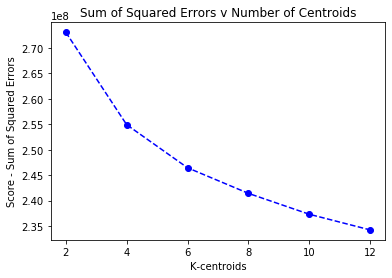

In [73]:
# Let's plot the scores against the number of clusters
plt.plot(range(2,14,2), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K-centroids');
plt.ylabel('Score - Sum of Squared Errors');
plt.title('Sum of Squared Errors v Number of Centroids');

In [74]:
# From the above chart, a slight elbow shape can be seen at 6, hence let's go with 6 clusters

kmeans_6 = KMeans(n_clusters=6, random_state=1)

# Then fit the model to your data using the fit method
model_general = kmeans_6.fit(X_pca_150)

# Finally predict the labels or clusters on the same data using the predict method 
predict_general_clusters = model_general.predict(X_pca_150)

In [75]:
predict_general_clusters

array([1, 2, 3, ..., 5, 1, 3], dtype=int32)

In [76]:
# look at the cluster number that the first few 

In [77]:
pd.Series(predict_general_clusters).value_counts().sort_values()

0     13123
2    114014
5    135663
4    153797
1    160917
3    168925
dtype: int64

In [78]:
# Now let's perform clustering on the customer data

In [79]:
df_customers = df_customers[df.columns]

In [80]:
# performm PCA on the customer data
customers_pca = pca_150.transform(df_customers)

In [87]:
customers_clusters = kmeans_6.predict(customers_pca)

In [88]:
customers_clusters

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

In [89]:
pd.Series(customers_clusters).value_counts().sort_values()

0       399
5    134247
dtype: int64

In [91]:
# this seems very interesting.
# it seems that the likely customers from the general population are already customers of the company.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')